In [ ]:
#pip install pyldavis==2.1.2
#nltk.download('wordnet')
#nltk.download('names')
#nltk.download('averaged_perceptron_tagger')
#!pip install --upgrade gensim

In [ ]:
import csv
from datetime import datetime as dt
import time
import pandas as pd
import numpy as np

# for text mining
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import pyLDAvis.gensim
import pickle
import pyLDAvis
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords, wordnet
import string

In [ ]:
# Read csv file with data
data_sample = pd.read_csv('Hotel_Cleaned.csv', delimiter = ',')

In [ ]:
# compiling stopwords from hotel names and sg locations.
add_stopwords = []

# utf-8-sig remove BOM if present
with open('additional_stopwords.csv', newline='', encoding = 'utf-8-sig') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        for cell in row:
            # extend to make it a flat list
            add_stopwords.extend(cell.lower().split())

# removing duplicates
add_stopwords = list(set(add_stopwords))

# combining all stopwords together
stop_words = stopwords.words('english') + add_stopwords

# male and female names for more stopwords
male_names = nltk.corpus.names.words('male.txt')
male_lower = [name.lower() for name in male_names]
female_names = nltk.corpus.names.words('female.txt')
female_lower = [name.lower() for name in female_names]

# combine names, remove duplicates
english_names = set(male_lower + female_lower)

In [ ]:
# Function for further preprocessing of data
def text_preprocess(text):
    # Tokenise the text
    tokens = word_tokenize(text.lower())

    # Remove stop words and names
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [token for token in tokens if token not in english_names]

    # remove further punctuation
    tokens = [token for token in tokens if token not in string.punctuation]

    # removing tokens shorter than 3 characters
    tokens = [token for token in tokens if len(token) > 2]

    # retaining alphabetic words only
    tokens = [token for token in tokens if token.isalpha()]
    return tokens

data_sample['Tokens'] = [text_preprocess(tokens) for tokens in \
                         data_sample['Reviews']]

# Function for lemmatization
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

# Function to retain only nouns, verbs, and adjectives
def pos_tag_nouns_verbs(lemmas):
    pos_tags = nltk.pos_tag(lemmas)
    return [token for token, tag in pos_tags if \
            tag.startswith('N') or tag.startswith('V') or \
            tag.startswith('JJ')]

# Apply lemmatize function and retain N, V, and JJ
# to each row in the Tokens column
data_sample['Lemmatized'] = data_sample['Tokens'].apply(lemmatize_tokens)
data_sample['Lemmatized'] = data_sample['Lemmatized'].apply(pos_tag_nouns_verbs)

# Creating bigrams and trigrams together
def make_bigrams(documents):
    # Create bigrams
    bigram = Phrases(documents, min_count=1, threshold=5, delimiter='_')
    bigram_phraser = Phraser(bigram)

    # Transform documents into bigram phrases
    documents_bigrams = [bigram_phraser[doc] for doc in documents]
    return documents_bigrams

data_sample['Lemmatized'] = make_bigrams(data_sample['Lemmatized'])

In [ ]:
# split data into positive and negative reviews
data_pos = data_sample.loc[data_sample['Sentiment'] == 'Positive']
data_neg = data_sample.loc[data_sample['Sentiment'] == 'Negative']

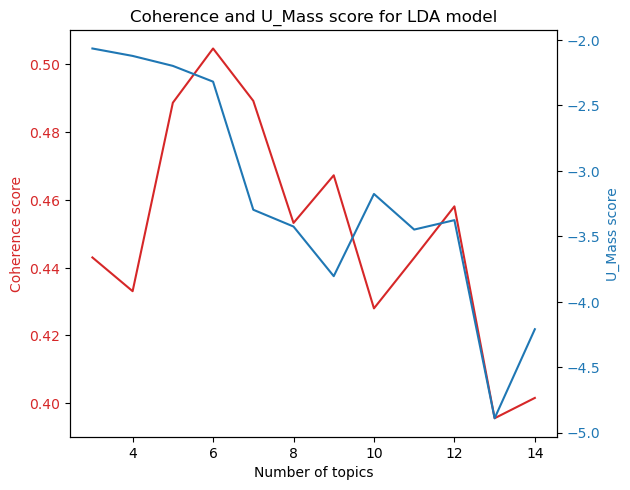

In [ ]:
# Evaluating optimal number of topics for LDA model

# Prepare the corpus, dictionary, and texts
texts = data_sample['Lemmatized']
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below = 2, no_above = 0.8)
corpus = [dictionary.doc2bow(text) for text in texts]

# Calculate the perplexity and coherence scores for each number of topics
coherence_scores = []
umass_scores = []

for num_topics in range(3, 15):
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=5)
    coherence_model_cv = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_cv = coherence_model_cv.get_coherence()
    coherence_scores.append(coherence_cv)
    coherence_model_umass = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='u_mass')
    coherence_umass = coherence_model_umass.get_coherence()
    umass_scores.append(coherence_umass)


# Plot the coherence scores and u_mass scores for different numbers of topics
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Number of topics')
ax1.set_ylabel('Coherence score', color=color)
ax1.plot(range(3, 15), coherence_scores, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('U_Mass score', color=color)  # we already handled the x-label with ax1
ax2.plot(range(3, 15), umass_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Coherence and U_Mass score for LDA model')
plt.show()



In [ ]:
# Creating a dictionary with tokens
dictionary = corpora.Dictionary(data_sample['Lemmatized'])
dictionary.filter_extremes(no_below = 3, no_above = 0.9)

# Creating a corpus
corpus = [dictionary.doc2bow(token) for token in data_sample['Lemmatized']]

In [ ]:
# Training LDA model
start_time = dt.now()
lda_model_31 = LdaModel(corpus=corpus, \
                     id2word=dictionary, \
                     num_topics=5,
                     passes=5, random_state = 31) #24? maybe 31

end_time = dt.now()
print(end_time - start_time)

# for i in range(lda_model.num_topics):
#     topic_terms = lda_model.get_topic_terms(i)
#     topic_terms_sum = sum(prob for _, prob in topic_terms)
#     normalized_topic_terms = [(term_id, prob/topic_terms_sum) for term_id, prob in topic_terms]
#     lda_model.get_topic_terms(i, len(topic_terms))
#     lda_model.set_topic_terms(i, normalized_topic_terms)

# interactive LDA model
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_31, corpus, dictionary)
pyLDAvis.display(LDAvis_prepared)

0:04:30.810323


C:\Users\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


In [ ]:
# interactive LDA model
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_31, corpus, dictionary)
pyLDAvis.display(LDAvis_prepared)

C:\Users\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


In [ ]:
# print out topic words
topic_word_list = [[] for l in range(5)]

for topic_id in range(5):
    topic_word_prob = lda_model_31.get_topic_terms(topic_id, topn = 50)

    # dictionary[pair[0]] to access word corresponding to id in dictionary
    top_topic_words = [dictionary[pair[0]] for pair in topic_word_prob]
    topic_word_list[topic_id] = top_topic_words

for i, words in enumerate(topic_word_list):
    print(f"Topic {i}: {words}")

Topic 0: ['staff', 'time', 'check', 'night', 'guest', 'service', 'booked', 'thing', 'got', 'came', 'day', 'said', 'reception', 'good', 'bed', 'booking', 'need', 'front_desk', 'went', 'call', 'checked', 'given', 'stayed', 'issue', 'people', 'small', 'hour', 'think', 'floor', 'left', 'work', 'make', 'know', 'made', 'called', 'bad', 'arrived', 'look', 'property', 'experience', 'housekeeping', 'ask', 'want', 'lobby', 'due', 'review', 'many', 'change', 'breakfast', 'found']
Topic 1: ['good', 'great', 'location', 'staff', 'breakfast', 'service', 'excellent', 'restaurant', 'food', 'area', 'friendly', 'located', 'comfortable', 'mrt', 'walking_distance', 'helpful', 'many', 'recommend', 'stayed', 'small', 'staff_helpful', 'spacious', 'facility', 'mrt_station', 'lot', 'walk', 'shopping', 'overall', 'convenient', 'quiet', 'easy', 'choice', 'everything', 'pool', 'perfect', 'stayed_night', 'amenity', 'time', 'close', 'mall', 'minute_walk', 'modern', 'best', 'staying', 'enjoyed', 'fantastic', 'recomm

In [ ]:
# save lda model's topics into csv
topic_header = [f'Topic {i+1}' for i in range(5)]
topic_word_list_transposed = list(zip(*topic_word_list))
with open('topic_list_31.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(topic_header)
    for row in topic_word_list_transposed:
        writer.writerow(row)

In [ ]:
# create for positive reviews
# Creating a dictionary with tokens
dictionary_pos = corpora.Dictionary(data_pos['Lemmatized'])
dictionary_pos.filter_extremes(no_below = 3, no_above = 0.9)

# Creating a corpus
corpus_pos = [dictionary_pos.doc2bow(token) for token in data_pos['Lemmatized']]

# Training LDA model
start_time = dt.now()
lda_model_pos = LdaModel(corpus=corpus_pos, \
                     id2word=dictionary_pos, \
                     num_topics=5,
                     passes=5, random_state = 31) #keep 31

end_time = dt.now()
print(end_time - start_time)

# for i in range(lda_model.num_topics):
#     topic_terms = lda_model.get_topic_terms(i)
#     topic_terms_sum = sum(prob for _, prob in topic_terms)
#     normalized_topic_terms = [(term_id, prob/topic_terms_sum) for term_id, prob in topic_terms]
#     lda_model.get_topic_terms(i, len(topic_terms))
#     lda_model.set_topic_terms(i, normalized_topic_terms)

# interactive LDA model
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_pos, corpus_pos, dictionary_pos)
pyLDAvis.display(LDAvis_prepared)

0:04:12.480118


C:\Users\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


In [ ]:
topic_word_list = [[] for l in range(5)]

for topic_id in range(5):
    topic_word_prob = lda_model_pos.get_topic_terms(topic_id, topn = 30)

    # dictionary[pair[0]] to access word corresponding to id in dictionary
    top_topic_words = [dictionary_pos[pair[0]] for pair in topic_word_prob]
    topic_word_list[topic_id] = top_topic_words

# save lda model's topics into csv
topic_header = [f'Topic {i+1}' for i in range(5)]
topic_word_list_transposed = list(zip(*topic_word_list))
with open('topic_list31_pos.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(topic_header)
    for row in topic_word_list_transposed:
        writer.writerow(row)

In [ ]:
# create for negative reviews
# Creating a dictionary with tokens
dictionary_neg = corpora.Dictionary(data_neg['Lemmatized'])
dictionary_neg.filter_extremes(no_below = 3, no_above = 0.9)

# Creating a corpus
corpus_neg = [dictionary_neg.doc2bow(token) for token in data_neg['Lemmatized']]

# Training LDA model
start_time = dt.now()
lda_model_neg = LdaModel(corpus=corpus_neg, \
                     id2word=dictionary_neg, \
                     num_topics=5,
                     passes=5, random_state = 32) #keep 30 or 32

end_time = dt.now()
print(end_time - start_time)

# for i in range(lda_model.num_topics):
#     topic_terms = lda_model.get_topic_terms(i)
#     topic_terms_sum = sum(prob for _, prob in topic_terms)
#     normalized_topic_terms = [(term_id, prob/topic_terms_sum) for term_id, prob in topic_terms]
#     lda_model.get_topic_terms(i, len(topic_terms))
#     lda_model.set_topic_terms(i, normalized_topic_terms)

# interactive LDA model
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_neg, corpus_neg, dictionary_neg)
pyLDAvis.display(LDAvis_prepared)

0:00:25.632352


C:\Users\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


In [ ]:
topic_word_list = [[] for l in range(5)]

for topic_id in range(5):
    topic_word_prob = lda_model_neg.get_topic_terms(topic_id, topn = 30)

    # dictionary[pair[0]] to access word corresponding to id in dictionary
    top_topic_words = [dictionary_neg[pair[0]] for pair in topic_word_prob]
    topic_word_list[topic_id] = top_topic_words

# save lda model's topics into csv
topic_header = [f'Topic {i+1}' for i in range(5)]
topic_word_list_transposed = list(zip(*topic_word_list))
with open('topic_list32_neg.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(topic_header)
    for row in topic_word_list_transposed:
        writer.writerow(row)

In [ ]:
# interactive LDA model
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(LDAvis_prepared)

C:\Users\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


In [ ]:
# append topic probabilities to current dataset.
topic_probs = []

for review in corpus:
    probs = lda_model_31.get_document_topics(review, minimum_probability= 0)
    topic_probs.append([p[1] for p in probs])

topic_columns = [f'Prob Topic {i+1}' for i in range(5)]
df_topics =pd.DataFrame(topic_probs, columns=topic_columns)

df_result = pd.concat([data_sample, df_topics], axis = 1)

# save data with topic probabilities into new csv
df_result.to_csv('data_topic_results_31.csv', index = False)

# Random Forest to Predict Sentiment Compound

In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz, plot_tree
from IPython.display import Image
from io import StringIO
!pip install graphviz
from graphviz import Source
!pip install pydotplus
import pydotplus
import os

from random import shuffle
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

HotelTrain = pd.read_csv('train_set.csv')
HotelTest = pd.read_csv('test_set.csv')

NameError: name 'pd' is not defined

In [2]:
def randomforest_model(X_train, X_test, y_train, y_test, imagename):

    rf = RandomForestRegressor(random_state=42)

    param_grid = {
        "n_estimators": [10, 20, 40, 100],
        "max_depth": [2, 3, 5, 8, 10],
        "max_features": ["sqrt", "log2"]
    }

    grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_rf = grid_search.best_estimator_
    print("Best hyperparameters:", grid_search.best_params_)

    # Fit the model on the training data and make predictions on the test data
    best_rf.fit(X_train, y_train)
    y_pred = best_rf.predict(X_test)

    # Calculate the testing accuracy score
    test_score = best_rf.score(X_test, y_test)
    print("Accuracy Score:", test_score)

    # Calculate the evaluation metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    # Print the evaluation metrics
    print('R2:', r2)
    print('Root Mean Squared Error:', rmse)
    print('Mean Absolute Error:', mae)

    # Print the feature importance
    importances = best_rf.feature_importances_
    feature_importances = dict(zip(X_train.columns, importances))
    used_features = [feature for feature, importance in feature_importances.items() if importance > 0]

    X_train_selected = X_train[used_features]
    X_test_selected = X_test[used_features]

    # Print out the used features, their importances, and their coefficients
    print("\nFeatures used in the Model:")
    for feature, importance in feature_importances.items():
        if importance > 0:
            print(f"{feature}: {importance} ({best_rf.feature_importances_[X_train.columns.get_loc(feature)]})")

    # Create and save the random forest diagram
    plt.figure(figsize=(20,10))
    plot_tree(best_rf.estimators_[0], feature_names=X_train.columns,
              class_names=True, filled=True, rounded=True)
    plt.show()


    os.environ["PATH"] += os.pathsep + 'C:\\Users\\Graphviz\\bin'
    dot_data = StringIO()
    export_graphviz(best_rf.estimators_[0], out_file=dot_data,
                    filled=True, rounded=True,
                    special_characters=True,
                    feature_names=X_train.columns, max_depth=3) # Set to 3 to make it look clearer

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#     Source.directory = "C:/Users/Graphviz/bin"
#     filename = imagename + 'i_rf' + '.png'
    graph.write_png('rf2_i.png')

In [ ]:
# preprocessing data for modelling
def data_preprocessing(df):
    df['Log_WordCount'] = np.log(df['Reviews_WordCount'])
    df = df.drop(['Hotel','Titles','Reviews','Dates','No_of_Reviews','Reviews_WordCount','Rating',
                  'Address','Sentiment_Pos','Sentiment_Neg','Sentiment_Neu','Sentiment','Year'], axis = 1)

    #not creating dummy columns for rating
    df = pd.get_dummies(df, columns = ['Travel_Type','Hotel_Class'],
                        drop_first = True)

    # filter out rows with #NAME or #N/A values
    mask = (df == '#NAME?') | (df == '#N/A') | (df.isna())
    df = df[~mask.any(axis=1)]

    # Convert Prob Topic columns to float
    df['Prob Topic 1'] = df['Prob Topic 1'].astype(float)
    df['Prob Topic 2'] = df['Prob Topic 2'].astype(float)
    df['Prob Topic 3'] = df['Prob Topic 3'].astype(float)
    df['Prob Topic 4'] = df['Prob Topic 4'].astype(float)
    df['Prob Topic 5'] = df['Prob Topic 5'].astype(float)

    return df

# preprocess datasets
HotelTrain_Processed = data_preprocessing(HotelTrain)
HotelTest_Processed = data_preprocessing(HotelTest)

Best hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Accuracy Score: 0.48650016027227505
R2: 0.48650016027227505
Root Mean Squared Error: 0.32286640664763183
Mean Absolute Error: 0.1859180994597385

Features used in the Model:
Review_Rating: 0.4192527317267504 (0.4192527317267504)
Location: 0.007904830471045473 (0.007904830471045473)
Cleanliness: 0.014714815802662323 (0.014714815802662323)
Service: 0.016453288549502336 (0.016453288549502336)
Value: 0.009382054969097966 (0.009382054969097966)
FreeParking: 0.001169598430467427 (0.001169598430467427)
FreeWifi: 0.0008747321071098476 (0.0008747321071098476)
FreeBreakfast: 0.0012648701444406944 (0.0012648701444406944)
Gym: 0.0024145803644801964 (0.0024145803644801964)
Pool: 0.0016517815742392535 (0.0016517815742392535)
Restaurant: 0.0012426513847458617 (0.0012426513847458617)
BarLounge: 0.0034778896395979706 (0.0034778896395979706)
TV: 0.0007248988733432924 (0.0007248988733432924)
EventFacilities: 0.0028144250

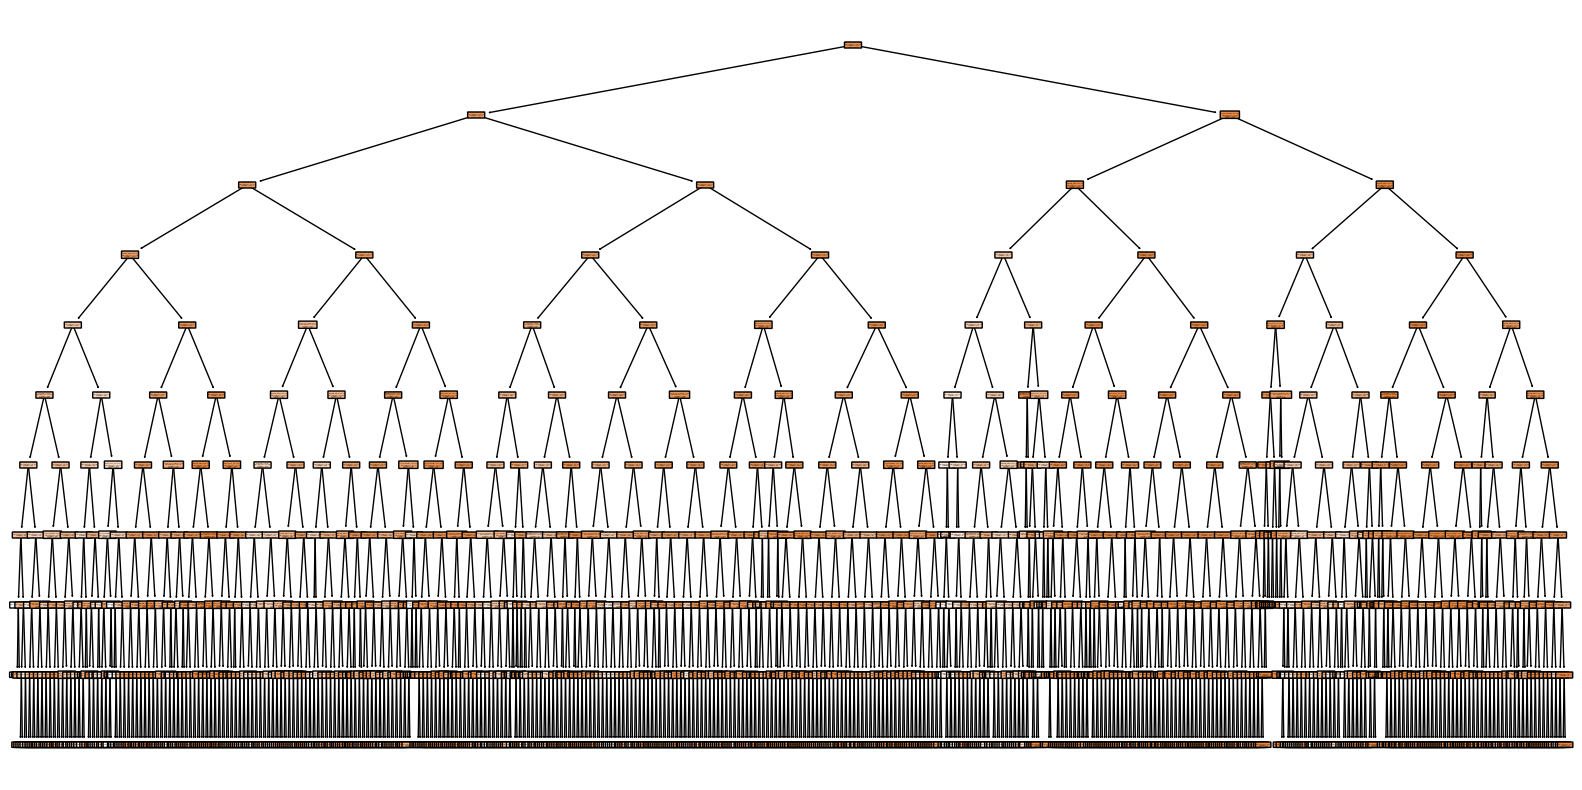

In [ ]:
# assigning training and testing variables for dv and ivs
y_train = HotelTrain_Processed['Sentiment_Compound']
x_train = HotelTrain_Processed.drop(['Sentiment_Compound'], axis = 1)
y_test = HotelTest_Processed['Sentiment_Compound']
x_test = HotelTest_Processed.drop(['Sentiment_Compound'], axis = 1)

randomforest_model(x_train, x_test, y_train, y_test, "RandomForest")